# Economic AI Agents Visualization

This notebook provides visualizations and analysis for the Economic AI Agents simulation data.

In [2]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import json

# Set up plotting style
plt.style.use('default')


In [5]:
# Load simulation data and extract agent energy trajectories
# Parameters: G+R (3,5,7,9), A (1,2,5,10), Replicates (0-9)

def extract_agent_energy_data(logs_dir='logs'):
    """
    Load all simulation trace files and extract energy trajectories for each agent
    Returns a DataFrame with energy data for all agents across all conditions
    """
    all_energy_data = []
    
    # Define parameter values based on your factorial design
    gr_values = [3, 5, 7, 9]  # G+R (Green + Red resources)
    a_values = [1, 2, 5, 10]   # A (Agents)
    replicates = list(range(10))  # 0-9
    
    # First, let's check what folders actually exist
    if not os.path.exists(logs_dir):
        print(f"Logs directory '{logs_dir}' not found!")
        return pd.DataFrame()
    
    folders = [f for f in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, f))]
    print(f"Found {len(folders)} folders in logs directory")
    
    # Extract parameters from actual folder names (JOB_R{red}_G{green}_C{consumption}_A{agents}_S{grid_size}_T{total_steps}_{replicate})
    loaded_conditions = []
    
    for folder in folders:
        try:
            # Parse folder name to extract parameters
            parts = folder.split('_')
            if len(parts) >= 7 and parts[0] == 'JOB':
                red_val = int(parts[1][1:])  # Remove 'R' prefix
                green_val = int(parts[2][1:])  # Remove 'G' prefix
                consumption = int(parts[3][1:])  # Remove 'C' prefix
                agents = int(parts[4][1:])  # Remove 'A' prefix
                grid_size = int(parts[5][1:])  # Remove 'S' prefix
                total_steps = int(parts[6][1:])  # Remove 'T' prefix
                replicate = int(parts[7])
                
                gr_total = red_val + green_val
                
                # Load the simulation trace file
                file_path = os.path.join(logs_dir, folder, "simulation_trace.csv")
                
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path)
                    
                    if not df.empty:
                        # Extract energy data for each agent
                        energy_data = df[['step', 'agent', 'energy']].copy()
                        
                        # Add experimental parameters
                        energy_data['red_resources'] = red_val
                        energy_data['green_resources'] = green_val
                        energy_data['gr_total'] = gr_total
                        energy_data['consumption_rate'] = consumption
                        energy_data['num_agents'] = agents
                        energy_data['grid_size'] = grid_size
                        energy_data['total_steps'] = total_steps
                        energy_data['replicate'] = replicate
                        energy_data['condition'] = f"GR{gr_total}_A{agents}"
                        energy_data['folder'] = folder
                        
                        all_energy_data.append(energy_data)
                        loaded_conditions.append((gr_total, agents, replicate))
                        
                        if len(loaded_conditions) % 20 == 0:  # Progress update every 20 files
                            print(f"Loaded {len(loaded_conditions)} files...")
                
        except (ValueError, IndexError) as e:
            print(f"Could not parse folder name: {folder} - {e}")
            continue
    
    if all_energy_data:
        # Combine all dataframes
        combined_df = pd.concat(all_energy_data, ignore_index=True)
        
        print(f"\n=== LOADING SUMMARY ===")
        print(f"Total files loaded: {len(loaded_conditions)}")
        print(f"Total energy records: {len(combined_df)}")
        print(f"Unique conditions: {combined_df['condition'].nunique()}")
        print(f"GR values found: {sorted(combined_df['gr_total'].unique())}")
        print(f"Agent counts found: {sorted(combined_df['num_agents'].unique())}")
        print(f"Replicates per condition: {combined_df.groupby('condition')['replicate'].nunique().min()}-{combined_df.groupby('condition')['replicate'].nunique().max()}")
        
        # Show summary by condition
        condition_summary = combined_df.groupby(['gr_total', 'num_agents']).agg({
            'replicate': 'nunique',
            'step': 'max',
            'agent': 'nunique'
        }).round(2)
        condition_summary.columns = ['num_replicates', 'max_steps', 'agents_per_sim']
        print(f"\nCondition summary:")
        print(condition_summary)
        
        return combined_df
    else:
        print("No data files found!")
        return pd.DataFrame()

# Load all the energy data
print("Loading all simulation energy data...")
energy_df = extract_agent_energy_data('logs')

if not energy_df.empty:
    print(f"\n=== DATA PREVIEW ===")
    print("First few rows:")
    print(energy_df.head())
    print(f"\nData shape: {energy_df.shape}")
    print(f"Columns: {list(energy_df.columns)}")
else:
    print("No data loaded!")

Loading all simulation energy data...
Found 160 folders in logs directory
Loaded 20 files...
Loaded 40 files...
Loaded 60 files...
Loaded 80 files...
Loaded 100 files...
Loaded 120 files...
Loaded 140 files...
Loaded 160 files...

=== LOADING SUMMARY ===
Total files loaded: 160
Total energy records: 59835
Unique conditions: 4
GR values found: [6, 10, 14, 18]
Agent counts found: [10]
Replicates per condition: 10-10

Condition summary:
                     num_replicates  max_steps  agents_per_sim
gr_total num_agents                                           
6        10                      10        100              10
10       10                      10        100              10
14       10                      10        100              10
18       10                      10        100              10

=== DATA PREVIEW ===
First few rows:
   step   agent  energy  red_resources  green_resources  gr_total  \
0     1  Agent1      19              7                7        14   
1     1 

=== DEBUGGING FOLDER NAMES ===
Sample folder names:
  JOB_R3_G3_C10_A10_S10_T100_0
  JOB_R3_G3_C10_A10_S10_T100_1
  JOB_R3_G3_C10_A10_S10_T100_2
  JOB_R3_G3_C10_A10_S10_T100_3
  JOB_R3_G3_C10_A10_S10_T100_4
  JOB_R3_G3_C10_A10_S10_T100_5
  JOB_R3_G3_C10_A10_S10_T100_6
  JOB_R3_G3_C10_A10_S10_T100_7
  JOB_R3_G3_C10_A10_S10_T100_8
  JOB_R3_G3_C10_A10_S10_T100_9

Unique conditions in data:
    Red  Green  Consumption  Count  GR_Total
0     3      3            1   2267         6
1     3      3            2   2634         6
2     3      3            5   4520         6
3     3      3           10   6780         6
4     5      5            1   2246        10
5     5      5            2   2580        10
6     5      5            5   3560        10
7     5      5           10   6150        10
8     7      7            1   2218        14
9     7      7            2   2672        14
10    7      7            5   4185        14
11    7      7           10   4690        14
12    9      9           

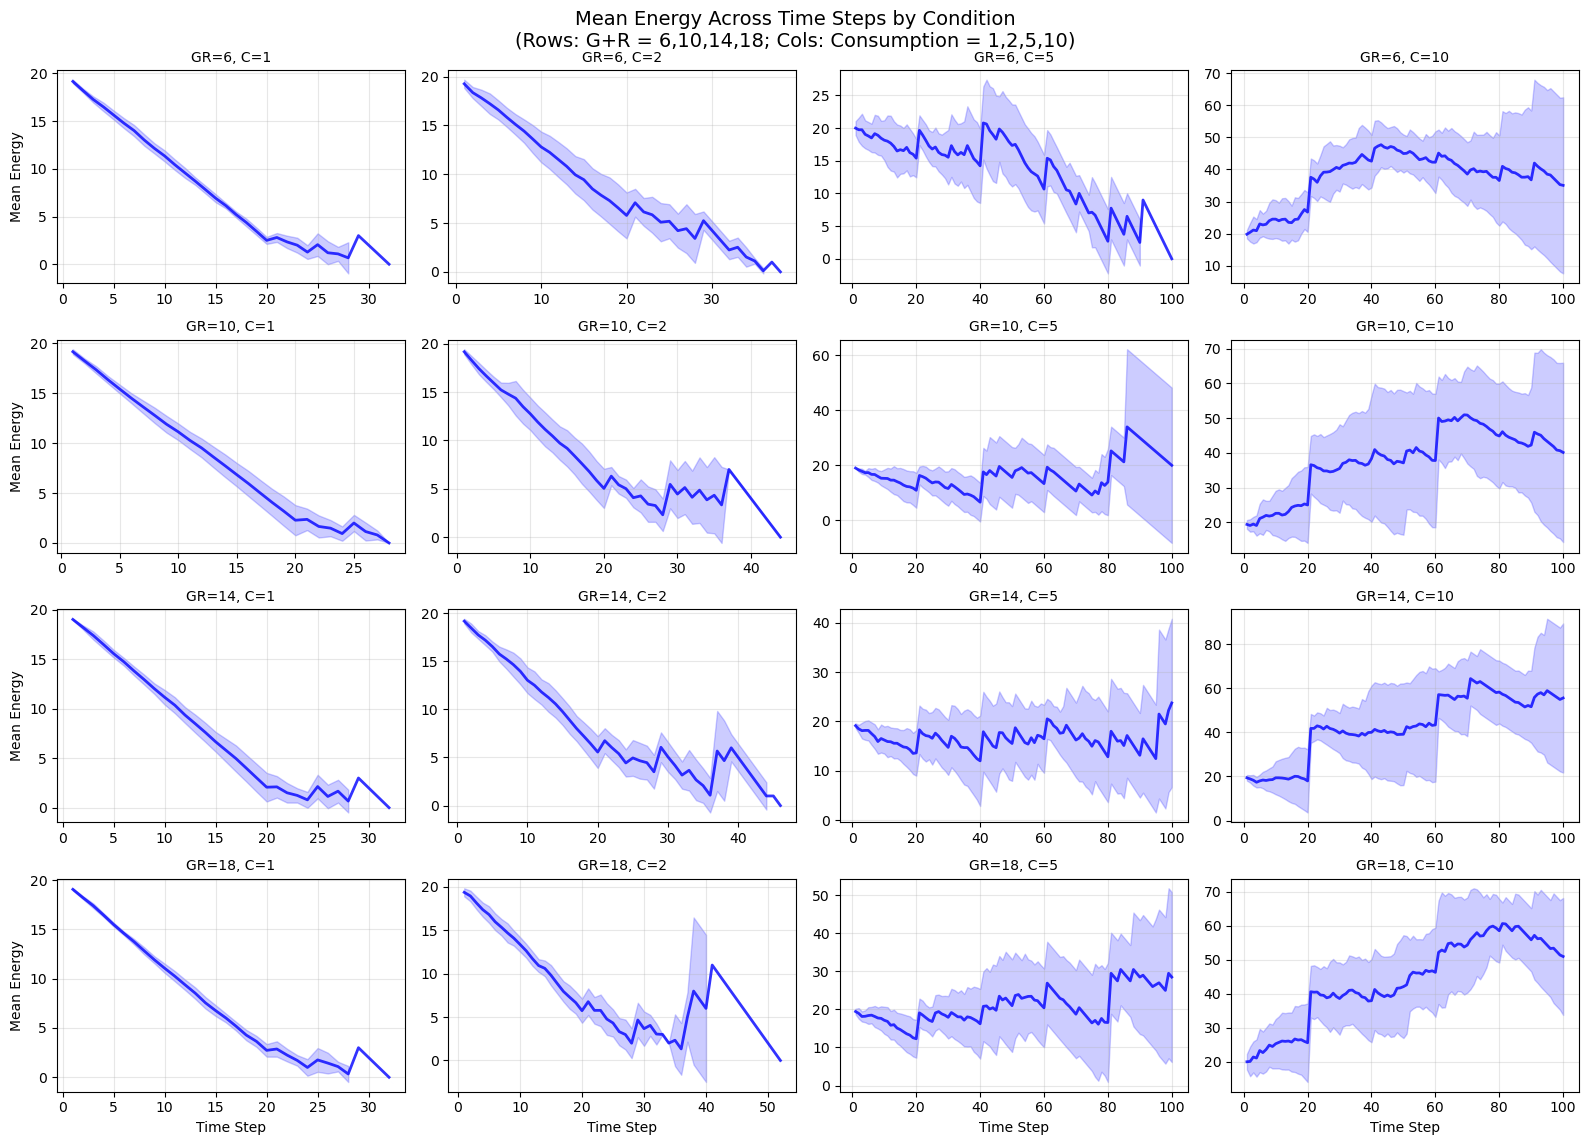

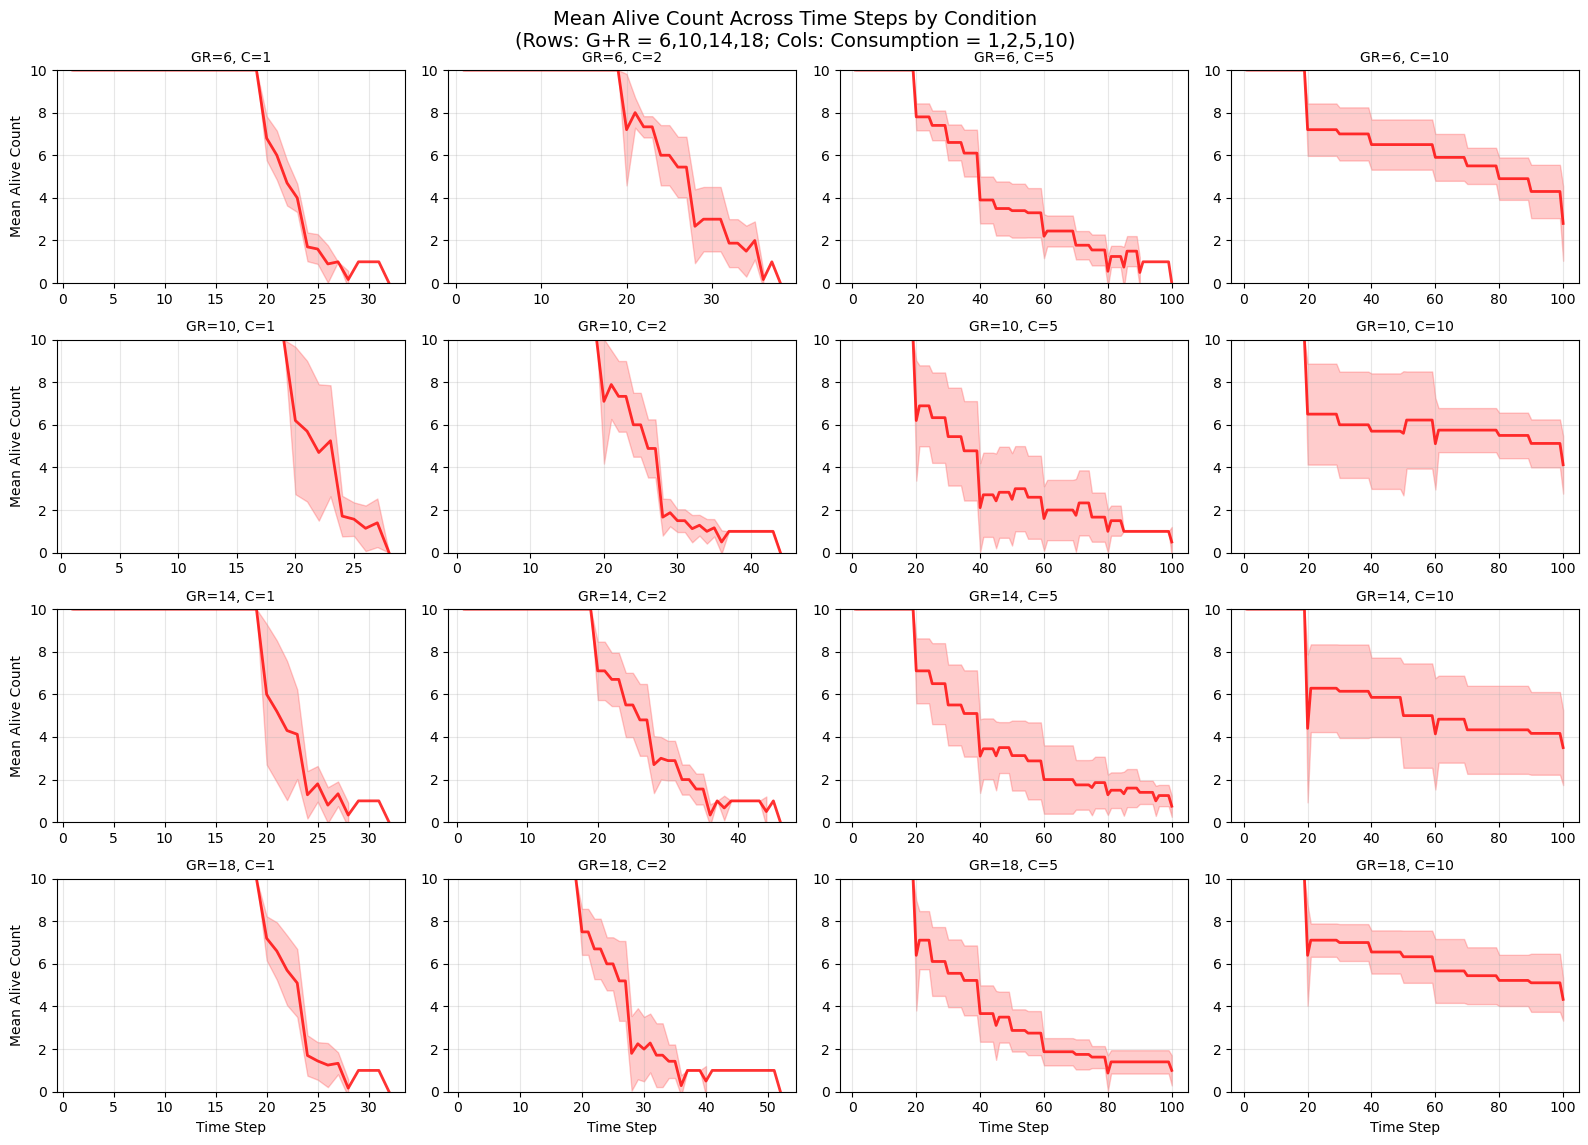


=== CONDITION AVAILABILITY ===
    GR_Total  Consumption_Rate  Data_Points
0          6                 1           32
1          6                 2           38
2          6                 5          100
3          6                10          100
4         10                 1           28
5         10                 2           44
6         10                 5          100
7         10                10          100
8         14                 1           32
9         14                 2           46
10        14                 5          100
11        14                10          100
12        18                 1           32
13        18                 2           52
14        18                 5          100
15        18                10          100


In [9]:
# First, let's check what the actual folder names and conditions are
print("=== DEBUGGING FOLDER NAMES ===")
folders = [f for f in os.listdir('logs') if os.path.isdir(os.path.join('logs', f))]
print(f"Sample folder names:")
for i, folder in enumerate(sorted(folders)[:10]):
    print(f"  {folder}")

print(f"\nUnique conditions in data:")
condition_check = energy_df.groupby(['red_resources', 'green_resources', 'consumption_rate']).size().reset_index()
condition_check.columns = ['Red', 'Green', 'Consumption', 'Count']
condition_check['GR_Total'] = condition_check['Red'] + condition_check['Green']
print(condition_check)

# Calculate mean energy and alive counts for all conditions
def calculate_summary_statistics_corrected(energy_df):
    """
    Calculate mean energy and mean alive counts for each condition at each time step
    Using GR total and consumption rate as the two factors
    """
    # Add alive indicator (energy > 0)
    energy_df['is_alive'] = energy_df['energy'] > 0
    
    # Group by condition, replicate, and step to get per-simulation summaries
    sim_summary = energy_df.groupby(['red_resources', 'green_resources', 'consumption_rate', 'replicate', 'step']).agg({
        'energy': 'mean',  # Mean energy across all agents in this simulation at this step
        'is_alive': 'sum'  # Count of alive agents in this simulation at this step
    }).reset_index()
    
    # Add GR total for easier plotting
    sim_summary['gr_total'] = sim_summary['red_resources'] + sim_summary['green_resources']
    
    # Now group by condition and step to get means across replicates
    condition_summary = sim_summary.groupby(['gr_total', 'consumption_rate', 'step']).agg({
        'energy': ['mean', 'std'],  # Mean and std of energy across replicates
        'is_alive': ['mean', 'std']  # Mean and std of alive count across replicates
    }).reset_index()
    
    # Flatten column names
    condition_summary.columns = ['gr_total', 'consumption_rate', 'step', 
                                'mean_energy', 'std_energy', 
                                'mean_alive', 'std_alive']
    
    return condition_summary

# Calculate summary statistics
print("\nCalculating summary statistics...")
summary_df = calculate_summary_statistics_corrected(energy_df)

# Define the actual experimental design
gr_values = [6, 10, 14, 18]  # Actual GR totals (3+3, 5+5, 7+7, 9+9)
consumption_values = [1, 2, 5, 10]  # Consumption rates

# Check what we actually have
actual_gr_values = sorted(summary_df['gr_total'].unique())
actual_consumption_values = sorted(summary_df['consumption_rate'].unique())

print(f"Expected GR values: {gr_values}")
print(f"Actual GR values: {actual_gr_values}")
print(f"Expected Consumption values: {consumption_values}")
print(f"Actual Consumption values: {actual_consumption_values}")

# Create 4x4 subplot for Mean Energy
fig1, axes1 = plt.subplots(4, 4, figsize=(16, 12))
fig1.suptitle('Mean Energy Across Time Steps by Condition\n(Rows: G+R = 6,10,14,18; Cols: Consumption = 1,2,5,10)', fontsize=14, y=0.95)

# Create 4x4 subplot for Mean Alive Count
fig2, axes2 = plt.subplots(4, 4, figsize=(16, 12))
fig2.suptitle('Mean Alive Count Across Time Steps by Condition\n(Rows: G+R = 6,10,14,18; Cols: Consumption = 1,2,5,10)', fontsize=14, y=0.95)

# Plot for each condition using correct grid layout
for i, gr in enumerate(gr_values):
    for j, consumption in enumerate(consumption_values):
        # Filter data for this condition
        condition_data = summary_df[(summary_df['gr_total'] == gr) & 
                                   (summary_df['consumption_rate'] == consumption)]
        
        if not condition_data.empty:
            # Plot Mean Energy
            ax1 = axes1[i, j]
            ax1.plot(condition_data['step'], condition_data['mean_energy'], 
                    color='blue', linewidth=2, alpha=0.8)
            
            # Add error bands (standard deviation)
            if condition_data['std_energy'].notna().any():
                ax1.fill_between(condition_data['step'], 
                               condition_data['mean_energy'] - condition_data['std_energy'],
                               condition_data['mean_energy'] + condition_data['std_energy'],
                               alpha=0.2, color='blue')
            
            ax1.set_title(f'GR={gr}, C={consumption}', fontsize=10)
            if i == 3:  # Bottom row
                ax1.set_xlabel('Time Step')
            if j == 0:  # Left column
                ax1.set_ylabel('Mean Energy')
            ax1.grid(True, alpha=0.3)
            
            # Plot Mean Alive Count
            ax2 = axes2[i, j]
            ax2.plot(condition_data['step'], condition_data['mean_alive'], 
                    color='red', linewidth=2, alpha=0.8)
            
            # Add error bands (standard deviation)
            if condition_data['std_alive'].notna().any():
                ax2.fill_between(condition_data['step'], 
                               condition_data['mean_alive'] - condition_data['std_alive'],
                               condition_data['mean_alive'] + condition_data['std_alive'],
                               alpha=0.2, color='red')
            
            ax2.set_title(f'GR={gr}, C={consumption}', fontsize=10)
            if i == 3:  # Bottom row
                ax2.set_xlabel('Time Step')
            if j == 0:  # Left column
                ax2.set_ylabel('Mean Alive Count')
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(0, 10)  # Max 10 agents
            
        else:
            # Empty subplot if no data for this condition
            axes1[i, j].text(0.5, 0.5, f'No data\nGR={gr}, C={consumption}', 
                           ha='center', va='center', transform=axes1[i, j].transAxes,
                           fontsize=10, color='red')
            axes1[i, j].set_title(f'GR={gr}, C={consumption}', fontsize=10)
            axes1[i, j].grid(True, alpha=0.3)
            if i == 3:
                axes1[i, j].set_xlabel('Time Step')
            if j == 0:
                axes1[i, j].set_ylabel('Mean Energy')
            
            axes2[i, j].text(0.5, 0.5, f'No data\nGR={gr}, C={consumption}', 
                           ha='center', va='center', transform=axes2[i, j].transAxes,
                           fontsize=10, color='red')
            axes2[i, j].set_title(f'GR={gr}, C={consumption}', fontsize=10)
            axes2[i, j].grid(True, alpha=0.3)
            if i == 3:
                axes2[i, j].set_xlabel('Time Step')
            if j == 0:
                axes2[i, j].set_ylabel('Mean Alive Count')

# Adjust layout
plt.figure(fig1.number)
plt.tight_layout()
plt.subplots_adjust(top=0.90)

plt.figure(fig2.number)
plt.tight_layout()
plt.subplots_adjust(top=0.90)

plt.show()

# Print condition availability
print(f"\n=== CONDITION AVAILABILITY ===")
available_conditions = summary_df.groupby(['gr_total', 'consumption_rate']).size().reset_index()
available_conditions.columns = ['GR_Total', 'Consumption_Rate', 'Data_Points']
print(available_conditions)

In [8]:
# Let's do a more detailed investigation of the folder structure
print("=== DETAILED FOLDER ANALYSIS ===")

# Get all folders in logs directory
logs_path = 'logs'
if os.path.exists(logs_path):
    all_folders = [f for f in os.listdir(logs_path) if os.path.isdir(os.path.join(logs_path, f))]
    print(f"Total folders found: {len(all_folders)}")
    
    # Parse all folder names to see what conditions we have
    parsed_conditions = []
    for folder in all_folders:
        try:
            parts = folder.split('_')
            if len(parts) >= 7 and parts[0] == 'JOB':
                red_val = int(parts[1][1:])  # Remove 'R' prefix
                green_val = int(parts[2][1:])  # Remove 'G' prefix
                consumption = int(parts[3][1:])  # Remove 'C' prefix
                agents = int(parts[4][1:])  # Remove 'A' prefix
                grid_size = int(parts[5][1:])  # Remove 'S' prefix
                total_steps = int(parts[6][1:])  # Remove 'T' prefix
                replicate = int(parts[7])
                
                gr_total = red_val + green_val
                parsed_conditions.append({
                    'folder': folder,
                    'red': red_val,
                    'green': green_val,
                    'gr_total': gr_total,
                    'agents': agents,
                    'consumption': consumption,
                    'grid_size': grid_size,
                    'total_steps': total_steps,
                    'replicate': replicate
                })
        except (ValueError, IndexError) as e:
            print(f"Could not parse: {folder}")
    
    # Convert to DataFrame for easier analysis
    parsed_df = pd.DataFrame(parsed_conditions)
    
    if not parsed_df.empty:
        print(f"\nParsed {len(parsed_df)} folders successfully")
        
        # Show unique combinations
        print("\nUnique GR values found:")
        print(sorted(parsed_df['gr_total'].unique()))
        
        print("\nUnique Agent counts found:")
        print(sorted(parsed_df['agents'].unique()))
        
        print("\nUnique combinations (GR, Agents):")
        combinations = parsed_df.groupby(['gr_total', 'agents']).size().reset_index()
        combinations.columns = ['GR_Total', 'Agents', 'Count']
        print(combinations)
        
        print("\nSample folder names by condition:")
        for gr in sorted(parsed_df['gr_total'].unique()):
            for agents in sorted(parsed_df['agents'].unique()):
                sample = parsed_df[(parsed_df['gr_total'] == gr) & (parsed_df['agents'] == agents)]
                if not sample.empty:
                    print(f"  GR={gr}, A={agents}: {sample.iloc[0]['folder']}")
    else:
        print("No folders could be parsed!")
else:
    print(f"Logs directory '{logs_path}' not found!")

=== DETAILED FOLDER ANALYSIS ===
Total folders found: 160

Parsed 160 folders successfully

Unique GR values found:
[6, 10, 14, 18]

Unique Agent counts found:
[10]

Unique combinations (GR, Agents):
   GR_Total  Agents  Count
0         6      10     40
1        10      10     40
2        14      10     40
3        18      10     40

Sample folder names by condition:
  GR=6, A=10: JOB_R3_G3_C2_A10_S10_T100_0
  GR=10, A=10: JOB_R5_G5_C2_A10_S10_T100_4
  GR=14, A=10: JOB_R7_G7_C1_A10_S10_T100_7
  GR=18, A=10: JOB_R9_G9_C2_A10_S10_T100_3
